In [11]:
!pip install wget
!pip install chart_studio

     |████████████████████████████████| 64 kB 1.9 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=1bf0463ddce5f3a0558b4cf5f3d9bb75073eba619d8b02f4bd9944dd6b571020
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [13]:
import wget
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [3]:
pd.set_option('precision', 2)

### Dowloading dataset

In [4]:
wget.download("https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_train.csv", './webis_train.csv')
wget.download("https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_test.csv", './webis_test.csv')

'./webis_test (1).csv'

### Reading dataset

In [5]:
df = pd.read_csv("webis_train.csv", delimiter=',', header=0)
# Removing nan values to simplify training process / I will only use postText to classify each instance
df_train = df[["postText", "truthClass"]].dropna()


df = pd.read_csv("webis_test.csv", delimiter=',', header=0)
# Removing nan values to simplify training process / I will only use postText to classify each instance
df_test = df[["postText", "truthClass"]].dropna()

### Analyzing length of instances per subset and class

Number of words per instance in training set


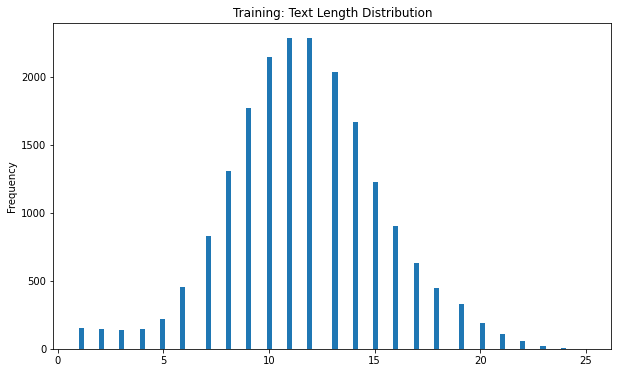

In [35]:
n_words = lambda x: len(x.split(" "))
df_train['postText_len'] = df_train['postText'].astype(str).apply(n_words)
df_test['postText_len'] = df_test['postText'].astype(str).apply(n_words)
print("Number of words per instance in training set")
df_train['postText_len'].plot(
    kind='hist',
    bins=100,
    title='Training: Text Length Distribution')

Number of words per instance in test set


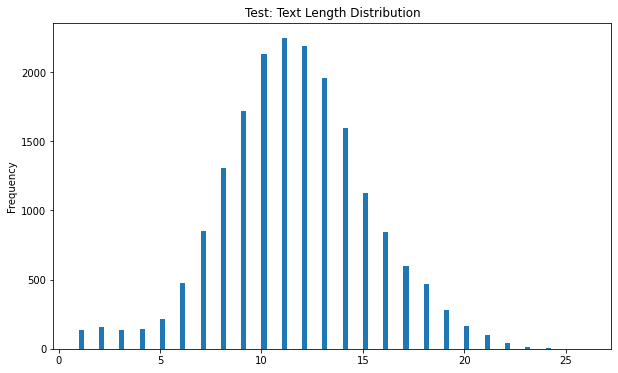

In [36]:
print("Number of words per instance in test set")
df_test['postText_len'].plot(
    kind='hist',
    bins=100,
    title='Test: Text Length Distribution')

Number of words per instance in training set


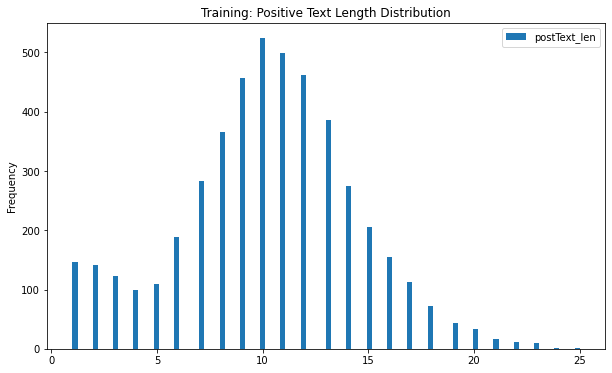

In [38]:
print("Number of words per instance in training set")
df_train.loc[df_train.truthClass == "clickbait", ['postText_len']].plot(
    kind='hist',
    bins=100,
    title='Training: Positive Text Length Distribution')

Number of words per instance in training set


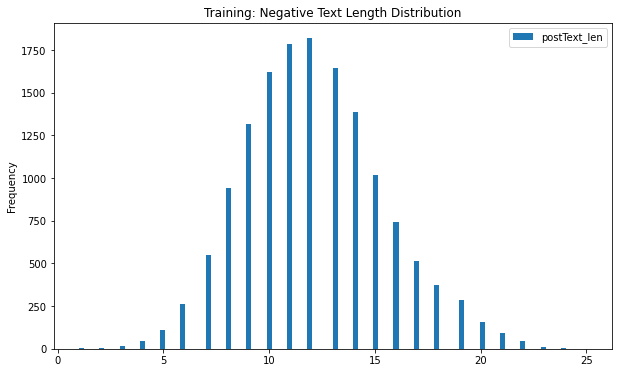

In [39]:
print("Number of words per instance in training set")
df_train.loc[df_train.truthClass != "clickbait", ['postText_len']].plot(
    kind='hist',
    bins=100,
    title='Training: Negative Text Length Distribution')

Acerca de la lonigitud de los mensajes. Utilizando un split basado unicamente en espacio, se puede observar que los datos de ambas clases (positiva y negativa), siguen patrones de longitud similares; concentrandose la maximas frecuencias sobretodo en mensajes de alrededor de 10 tokens. En un principio es de esperar que no haya ningún problema con limitaciones de tamaño impuestas por BERT y similares.


### Analyzing distribution of classes

> Bloque con sangría




In [44]:
print("Training data: Number of negative instances:", len(df_train.loc[df_train.truthClass != "clickbait"]))
print("Training data: Number of positive instances:", len(df_train.loc[df_train.truthClass == "clickbait"]))

Training data: Number of negative instances: 14768
Training data: Number of positive instances: 4716


In [45]:
print("Test data: Number of negative instances:", len(df_test.loc[df_test.truthClass != "clickbait"]))
print("Test data: Number of positive instances:", len(df_test.loc[df_test.truthClass == "clickbait"]))

Test data: Number of negative instances: 14455
Test data: Number of positive instances: 4458


Este problema se presenta como una tarea de clasificación con distribuciones entre clases desbalanceadas. Enfoques como medidas de evaluación Macro, permitiran conocer el performance de los sistemas desarrollados prestando detalle a la clase minoritaria i.e. la relevante en este caso.

### Analyzing most frequent words per class

In [56]:
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

most_frequent_words_neg = Counter([x for x in " ".join(df_train.loc[df_train.truthClass != "clickbait", "postText"]).lower().split() if x not in stopwords.words("english")]).most_common(100)

most_frequent_words_pos = Counter([x for x in " ".join(df_train.loc[df_train.truthClass == "clickbait", "postText"]).lower().split() if x not in stopwords.words("english")]).most_common(100)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
most_frequent_words = {x:y
    for x,y in most_frequent_words_neg
}
for x, y in most_frequent_words_pos:
  most_frequent_words[x] = most_frequent_words.get(x, 0)-y

In [58]:
for x in most_frequent_words:
  print("El termino:", x, "aparece ", most_frequent_words[x], "veces en el conjunto negativo que en el positvo.")

El termino: trump aparece  1154 veces en el conjunto negativo que en el positvo.
El termino: new aparece  687 veces en el conjunto negativo que en el positvo.
El termino: says aparece  597 veces en el conjunto negativo que en el positvo.
El termino: via aparece  351 veces en el conjunto negativo que en el positvo.
El termino: trump's aparece  340 veces en el conjunto negativo que en el positvo.
El termino: donald aparece  322 veces en el conjunto negativo que en el positvo.
El termino: president aparece  339 veces en el conjunto negativo que en el positvo.
El termino: first aparece  306 veces en el conjunto negativo que en el positvo.
El termino: us aparece  262 veces en el conjunto negativo que en el positvo.
El termino: u.s. aparece  296 veces en el conjunto negativo que en el positvo.
El termino: people aparece  139 veces en el conjunto negativo que en el positvo.
El termino: one aparece  159 veces en el conjunto negativo que en el positvo.
El termino: house aparece  224 veces en el

La frecuencia de los terminos es un factor que se puede ver comprometido por el número de documentos de cada clase. En sentido destaca la frecuencia > 0 del termino Trump (trump+Trump). Una forma de segmentar estos valores es estudiando el sentimiento en el cual se contextualizan estas menciones. Por otro lado, indicando frecuencias < 0 una presencia sobretodo en la clase "clickbait", destacan propias de anuncios: "sex", "love", "biggest".

In [81]:
import collections
def ngrams(text, n=2):
     return zip(*[text[i:] for i in range(n)])
ngram_counts_neg = collections.Counter(ngrams(" ".join(df_train.loc[df_train.truthClass != "clickbait", "postText"]).lower().split(), 3)).most_common(100)
ngram_counts_post = collections.Counter(ngrams(" ".join(df_train.loc[df_train.truthClass == "clickbait", "postText"]).lower().split(), 3)).most_common(100)

In [82]:
most_frequent_ngrams = {" ".join(terms):y
    for terms, y in ngram_counts_neg
}
for x, y in ngram_counts_post:
  most_frequent_ngrams[" ".join(x)] = most_frequent_ngrams.get(" ".join(x), 0)-y

In [84]:
most_frequent_ngrams = {k: v for k, v in sorted(most_frequent_ngrams.items(), key=lambda item: item[1])}

In [85]:
for x in most_frequent_ngrams:
  print("El termino:", x, "aparece ", most_frequent_ngrams[x], "veces en el conjunto negativo que en el positvo.")

El termino: you need to aparece  -36 veces en el conjunto negativo que en el positvo.
El termino: from the day aparece  -28 veces en el conjunto negativo que en el positvo.
El termino: stories from the aparece  -25 veces en el conjunto negativo que en el positvo.
El termino: these are the aparece  -24 veces en el conjunto negativo que en el positvo.
El termino: need to know aparece  -20 veces en el conjunto negativo que en el positvo.
El termino: of the most aparece  -19 veces en el conjunto negativo que en el positvo.
El termino: briefing: here's what aparece  -18 veces en el conjunto negativo que en el positvo.
El termino: #entertainment stories from aparece  -17 veces en el conjunto negativo que en el positvo.
El termino: will make you aparece  -17 veces en el conjunto negativo que en el positvo.
El termino: #news stories from aparece  -16 veces en el conjunto negativo que en el positvo.
El termino: know about the aparece  -15 veces en el conjunto negativo que en el positvo.
El term

Extendiendo el analisis de unigramas a trigramas, podemos observar que la clase "clickbait" concentra mensajes como "you need to", "will make you"... que asemejan mas a lo que cabría esperar de esta clase. Sobretodo por que son mensajes explicitamente dirigidos hacia el lector.

### Sentiment Analysis

In [87]:
from textblob import TextBlob

In [95]:
polarity_neg = []
subjectivity_neg = []
for instance in df_train.loc[df_train.truthClass != "clickbait", "postText"]:
  s = TextBlob(instance).sentiment
  polarity_neg.append(s.polarity)
  subjectivity_neg.append(s.subjectivity)
polarity_pos = []
subjectivity_pos = []
for instance in df_train.loc[df_train.truthClass == "clickbait", "postText"]:
  s = TextBlob(instance).sentiment
  polarity_pos.append(s.polarity)
  subjectivity_pos.append(s.subjectivity)

In [96]:
print("Polarity analysis")
print("===============================")
print("Average Polarity scores NEGATIVE CLASS:", sum(polarity_neg)/len(polarity_neg))
print("Avergage Polarity scores POSITIVE CLASS:", sum(polarity_pos)/len(polarity_pos))
print("Min Polarity scores NEGATIVE CLASS:", min(polarity_neg))
print("Min Polarity scores POSITIVE CLASS:", min(polarity_pos))
print("Max Polarity scores NEGATIVE CLASS:", max(polarity_neg))
print("Max Polarity scores POSITIVE CLASS:", max(polarity_pos))
print("\n\n")
print("Subjectivity analysis")
print("===============================")
print("Average Subjectivity scores NEGATIVE CLASS:", sum(subjectivity_neg)/len(subjectivity_neg))
print("Avergage Subjectivity scores POSITIVE CLASS:", sum(subjectivity_pos)/len(subjectivity_pos))
print("Min Subjectivity scores NEGATIVE CLASS:", min(subjectivity_neg))
print("Min Subjectivity scores POSITIVE CLASS:", min(subjectivity_pos))
print("Max Subjectivity scores NEGATIVE CLASS:", max(subjectivity_neg))
print("Max Subjectivity scores POSITIVE CLASS:", max(subjectivity_pos))

Polarity analysis
Average Polarity scores NEGATIVE CLASS: 0.04885960892821125
Avergage Polarity scores POSITIVE CLASS: 0.09154955352984637
Min Polarity scores NEGATIVE CLASS: -1.0
Min Polarity scores POSITIVE CLASS: -1.0
Max Polarity scores NEGATIVE CLASS: 1.0
Max Polarity scores POSITIVE CLASS: 1.0



Subjectivity analysis
Average Subjectivity scores NEGATIVE CLASS: 0.2648735186161555
Avergage Subjectivity scores POSITIVE CLASS: 0.3246519286638034
Min Subjectivity scores NEGATIVE CLASS: 0.0
Min Subjectivity scores POSITIVE CLASS: 0.0
Max Subjectivity scores NEGATIVE CLASS: 1.0
Max Subjectivity scores POSITIVE CLASS: 1.0


Ambas clases tienden a usar estructuras neutras en cuanto a un analisis de sentimiento (basico). Destaca la feature Subjectivity, aunque no en gran medida.